## Import Libraries

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import datetime
import re
from matplotlib import rcParams

## Import Dataset

In [2]:
df = pd.read_csv('data_collection/data.csv')
df.shape

(145, 4)

In [3]:
#drop all rows with missing articles
df.dropna(inplace=True)


## Data Cleaning / Preprocessing

In [4]:
#create a function that removes any puncuation and numbers and converts all letters to lower case
import re

def clean_text(string):
    clean_text = re.sub("[^a-zA-Z\s]", " ", string)
    #covert all test to lowercase
    lower_text = clean_text.lower()
    single_white_space_text = re.sub("\s+", " ", lower_text)
    return single_white_space_text

In [5]:
#apply clean_text function to every article and create new feature

df['clean_text'] = df.text.apply(lambda x: clean_text(x))


In [6]:
#now lets tokenize each review so we have a list of words for each document

def text_preprocessor(string):
    tokenize_review = string.split()
    word_list = []
    #let's remove any word that has less than 3 letters. this will take care of indefinite articles and former contractions that 
    #resulted in single letter words after removing punctuations.
    for word in tokenize_review:
        if len(word) > 2:
            word_list.append(word)
    #now let's remove english stopwords
    filtered_wordlist = []
    for word in word_list:
        if word not in stopwords.words('english'):
            filtered_wordlist.append(word)
    #now let's lemmatize each item so that words with similar inflections will be counted as one item
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word in filtered_wordlist:
        lemmatized_words.append(lemmatizer.lemmatize(word))
    

    return ' '.join(lemmatized_words)                        
        

    

In [7]:
#now let's apply the the text_preprocessor to each article and create a new feature

df['processed_text'] = df.clean_text.apply(lambda x: text_preprocessor(x))
df['processed_text']

0      dreading way inevitably ruin hbo actually like...
1      netflix new documentary former first lady mich...
2      finally caught amazon series wanting watch sin...
3      move seems utterly obvious soon announced nich...
4      taika waititi direct write new movie theatrica...
                             ...                        
139    begin tale ran somehow returned even longer se...
140    finished watching geralt grimace way eight epi...
141    phoebe waller bridge great year fresh second s...
142    baby yoda return second season next fall execu...
144    two month ago premiere disney made joke friend...
Name: processed_text, Length: 144, dtype: object

### Datetime

In [8]:
#After closer investigation of the article publish date, I noticed that the date is in a string format and has alot of extra
#characters that are unnecessary. Firstly, let use regex to clean it up a bit before we change the data type

df['date'] = df.date.apply(lambda x: x[11:23])


In [9]:
#now that we got that cleaned up, let's convert the string to a datetime object
df['date'] = pd.to_datetime(df['date'])

### Save cleaned dataframe to new csv file

In [10]:
df.to_csv('clean_df.csv')

### Open clean dataframe

In [11]:
df1 = pd.read_csv('clean_df.csv', index_col=0)


## Feature Engineering

In [12]:
#let's create a new date column so that we can look at the distribution of reviews written by month

df1['YearMonth'] = pd.to_datetime(df1['date']) - pd.offsets.MonthBegin(1)
df1['YearMonth'] = df1['YearMonth'].astype('str')

In [18]:
#how words are in each review after processing
import ast

# df1['processed_text'] = df1['processed_text'].apply(lambda x: ast.literal_eval(x))

df1['word_count'] = df1['processed_text'].apply(lambda x: len(x.split()))


## Exploratory Analysis

### Find Most common words from December 19 - June 2020

In [45]:
#Most common words in corpus
def find_meaningful_words(documents, max_word_occ):

    from collections import Counter

    corpus = ""
    for review in documents:
        corpus += review
    word_list = corpus.split()
    counter = Counter(word_list)
    word_dict = dict(counter)
    meaningful_words = []
    for k,v in word_dict.items():
        if v < max_word_occ:
            meaningful_words.append(k)
    return meaningful_words

def extract_meaningfull_words(document, meaningful_words):
    filtered_words = []
    for word in document.split():
        if word in meaningful_words:
            filtered_words.append(word)
    return ' '.join(filtered_words)


In [49]:
meaningful_words = find_meaningful_words(df1['processed_text'], 20)

In [21]:
df1['meaningfull_words_text'] = df1['processed_text'].apply(lambda x: extract_meaningfull_words(x, meaningful_words))

### Save Dataframe

In [4]:
# df1.to_csv('data_sets\clean_df2.csv')
df2 = pd.read_csv('data_sets\clean_df2.csv', index_col=0)


### Subset dataset by month

In [7]:
#organize dataset by month and as each as its own csv file

months = months = list(df2['YearMonth'].unique())
for month in months:
    month_df = df2.loc[df2['YearMonth'] == month]
    month_df.to_csv('data_sets\{}.csv'.format(month))


### Trending Terms by Month

In [8]:
#open up month dataframes

dec_19df = pd.read_csv('data_sets/2019-12-01.csv', index_col=0)
jan_20df = pd.read_csv('data_sets/2020-01-01.csv', index_col=0)
feb_20df = pd.read_csv('data_sets/2020-02-01.csv', index_col=0)
mar_20df = pd.read_csv('data_sets/2020-03-01.csv', index_col=0)
april_20df = pd.read_csv('data_sets/2020-04-01.csv', index_col=0)
may_20df = pd.read_csv('data_sets/2020-05-01.csv', index_col=0)

In [14]:
from wordcloud import WordCloud, STOPWORDS

#### December 19

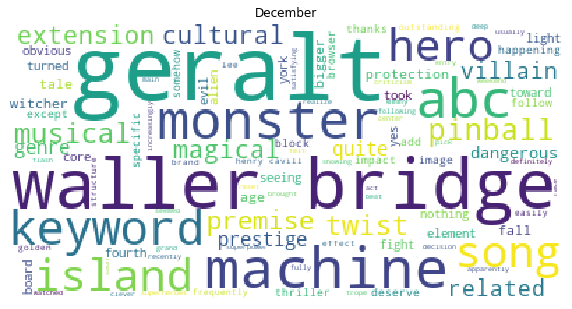

In [55]:
def create_wordcloud(documents, title):

    all_text = ' '.join(documents)

    wordcloud = WordCloud(background_color="white", max_words=100, collocations=True).generate(all_text)

    rcParams['figure.figsize'] = 10, 20
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

create_wordcloud(dec_19df['meaningfull_words_text'], 'December')

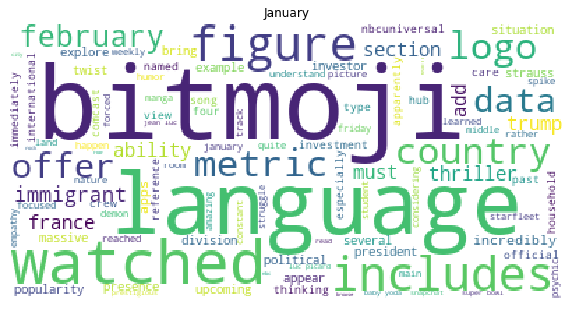

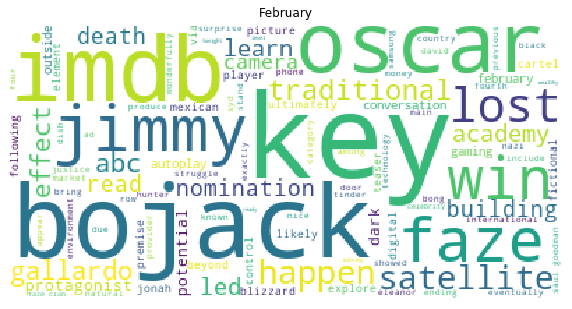

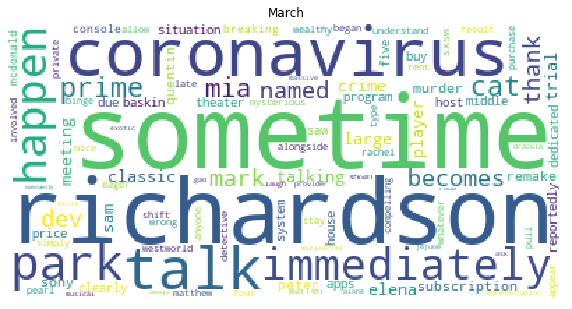

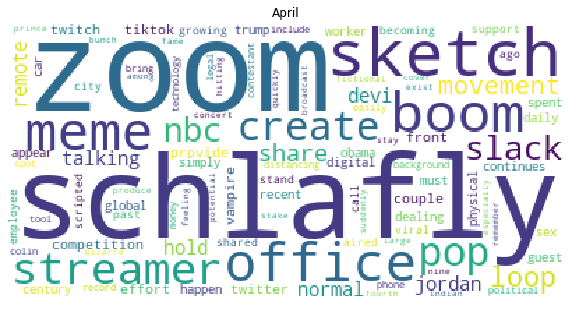

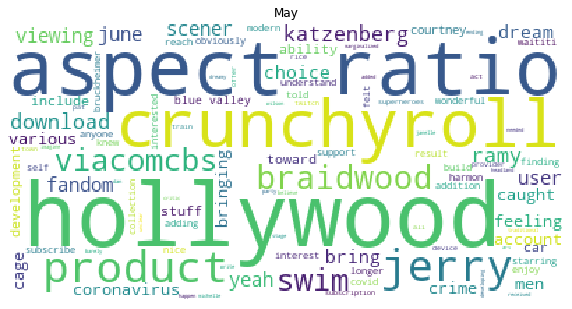

In [60]:
create_wordcloud(jan_20df['meaningfull_words_text'], 'January')
create_wordcloud(feb_20df['meaningfull_words_text'], 'February')
create_wordcloud(mar_20df['meaningfull_words_text'], 'March')
create_wordcloud(april_20df['meaningfull_words_text'], 'April')
create_wordcloud(may_20df['meaningfull_words_text'], 'May')

### How Regular Staff Writers Does The Verge Have?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

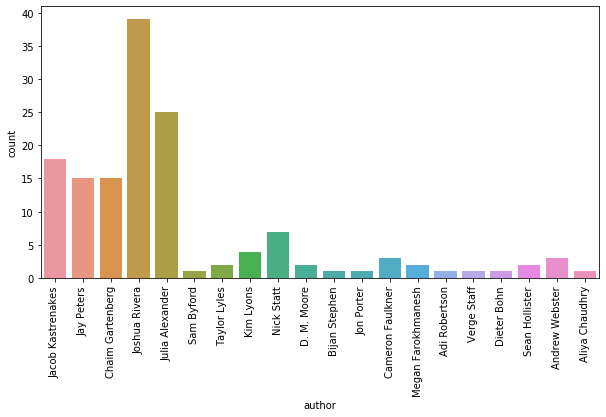

In [15]:
plt.figure(figsize=(10,5))
sns.countplot(data=df1, x='author' )
plt.xticks(rotation=90)


 
Looking at the chart below there is a pretty significant dropoff after the first 5 writers, so we're gonna let 15 be the threshold for being a "regular" staff writer

### How many reviews were published for each month?

Text(0.5, 0, 'Month')

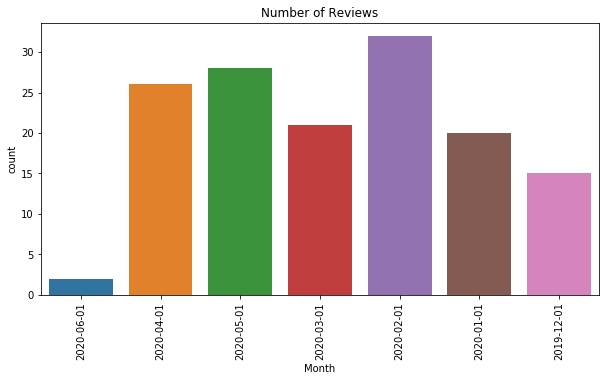

In [62]:
plt.figure(figsize=(10,5))
sns.countplot(data=df2, x='YearMonth')
plt.xticks(rotation=90)
plt.title('Number of Reviews')
plt.xlabel('Month')

 
Looks like February is the peak of number of posts but dropped dramatically a month later. Makes sense since March is when the coronavirus pandemic shutdown most of the country (and World). 
Let's examine the number of writers that were active for each month and see if there's a correlation


### How many writers were active during this time?

In [67]:
author_month_df = df1.groupby('YearMonth')['author'].count().reset_index()

In [70]:
author_month_df

# plt.figure(figsize=(10,5))
# sns.barplot(data=author_month_df, x='author', y='YearMonth')
# plt.xticks(rotation=90)

,YearMonth,author
0,2019-12-01,15
1,2020-01-01,20
2,2020-02-01,32
3,2020-03-01,21
4,2020-04-01,26
5,2020-05-01,28
6,2020-06-01,2


In [57]:
#lets create a word frequency dictionary of our corpus
import ast

def word_dict(pd_series):
    for item in pd_series:
        wordfreq = {}
        for word in item:
            if word not in wordfreq.keys():
                wordfreq[word] = 1
            else:
                wordfreq[word] += 1

    return wordfreq

In [59]:
wordfreq = word_dict(df1['processed_text'])

## Modeling

### 

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, homogeneity_score

In [35]:
def get_clusters(corpus, num_clusters, n_grams):

    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=n_grams)
    X = vectorizer.fit_transform(corpus)

    model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
    model.fit(X)

    print("Top terms per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(num_clusters):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :5]:
            print(' %s' % terms[ind]),
        print('\n')
        print

In [36]:
get_clusters(df1['processed_text'] , 4, (2,2))

Top terms per cluster:
Cluster 0: <function homogeneity_score at 0x0000025CC41F75E8>
 talosian alien
 couch gag
 cbs access
 pilot episode
 company series


Cluster 1: <function homogeneity_score at 0x0000025CC41F75E8>
 video game
 hbo max
 streaming service
 second season
 waller bridge


Cluster 2: <function homogeneity_score at 0x0000025CC41F75E8>
 hbo max
 feel like
 streaming service
 live action
 pop culture


Cluster 3: <function homogeneity_score at 0x0000025CC41F75E8>
 look like
 disney plus
 streaming service
 trailer week
 film come




In [40]:
# def get_clusters(corpus, num_clusters, n_grams):

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2))
X = vectorizer.fit_transform(df1['processed_text'])

model = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
model.


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=4, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)